# Vector Search with FAISS
In this notebook, we're going to learn about vector search with the FAISS library.

In [500]:
!pip install faiss-cpu pandas numpy

In [504]:
import faiss
import copy
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly_functions import generate_high_contrast_colors, zoom_in

In [529]:
dimensions = 2
number_of_vectors = 1_000
vectors = np.random.random((number_of_vectors, dimensions)).astype(np.float32) 

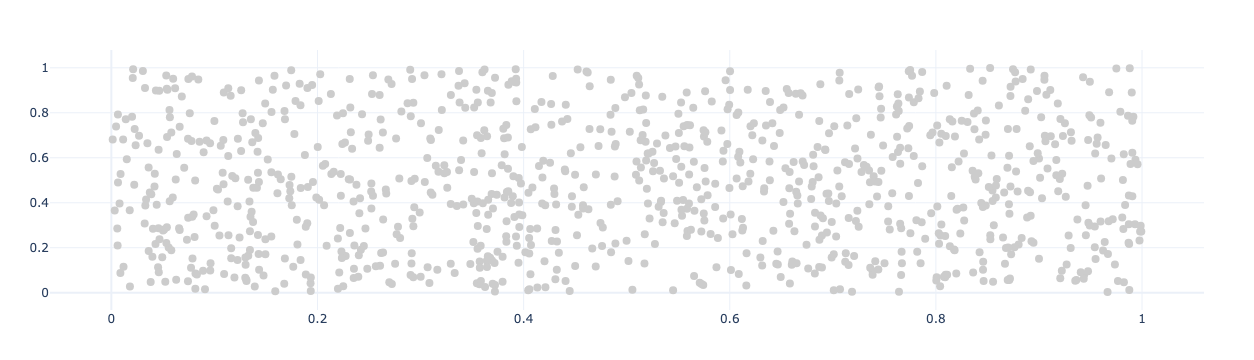

In [530]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=vectors[:, 0], y=vectors[:, 1], mode='markers', marker=dict(size=8, color='#CCCCCC'), name="Data"))
fig.update_layout(template="plotly_white", margin=dict(t=50, b=50, l=50, r=50))
fig

In [507]:
search_vector = np.array([[0.5, 0.5]])

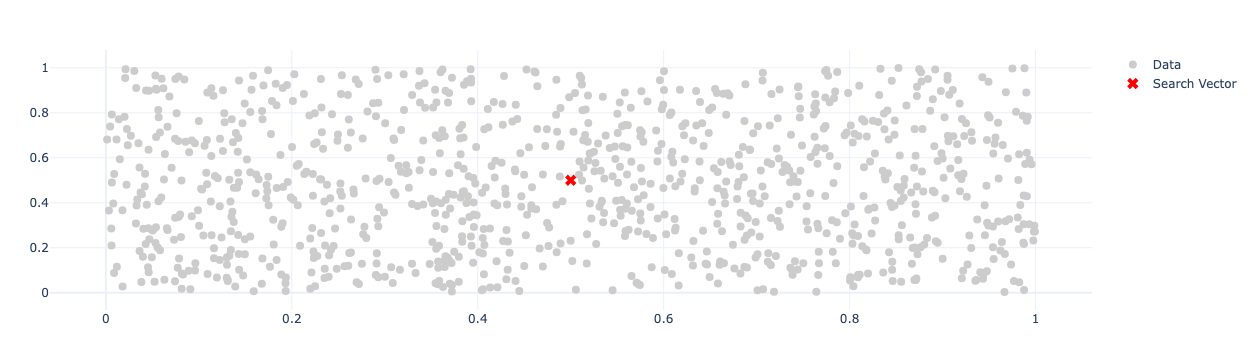

In [531]:
nn_fig = copy.deepcopy(fig)
nn_fig.add_trace(go.Scatter(x=search_vector[:, 0], y=search_vector[:, 1], mode='markers', marker=dict(size=10, color='red', symbol='x'), name="Search Vector"))
nn_fig

# The Brute Force Approach
The simplest index compares each vector with all the other ones to find the nearest neighbours.

In [532]:
index = faiss.IndexFlatL2(dimensions)
index.add(vectors)

In [533]:
%%time
distances, indices = index.search(search_vector, k=10)

df_flat = pd.DataFrame({
  "id": indices[0],
  "vector": [vectors[id] for id in indices[0]],
  "distance": distances[0],
})
df_flat

CPU times: user 761 µs, sys: 162 µs, total: 923 µs
Wall time: 853 µs


,id,vector,distance
0,912,"[0.51214206, 0.49906242]",0.000148
1,645,"[0.4883095, 0.516822]",0.000420
2,934,"[0.5089926, 0.524738]",0.000693
3,448,"[0.5361612, 0.50799084]",0.001371
4,563,"[0.47009, 0.52610755]",0.001576
5,246,"[0.5195626, 0.46237582]",0.001798
6,757,"[0.52554846, 0.54038584]",0.002284
7,804,"[0.5450408, 0.5175769]",0.002338
8,291,"[0.55084914, 0.48862478]",0.002715
9,893,"[0.4583345, 0.4686835]",0.002717


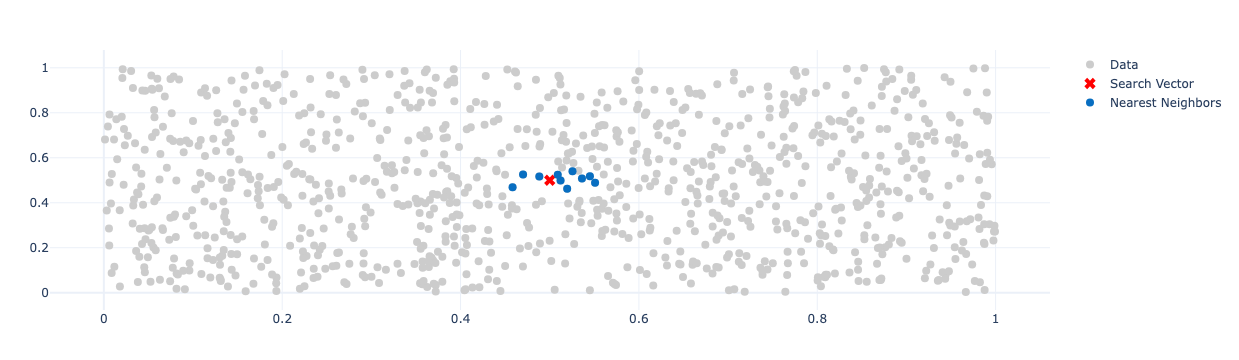

In [534]:
nn_vectors = np.array(df_flat["vector"].tolist())
nn_fig.add_trace(go.Scatter(x=nn_vectors[:, 0], y=nn_vectors[:, 1], mode='markers', marker=dict(size=8, color='#086ec1'), name="Nearest Neighbors"))
nn_fig

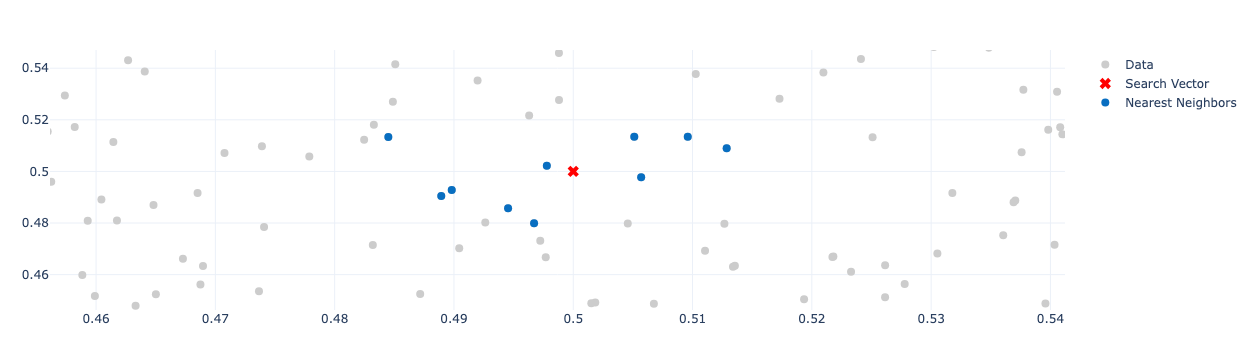

In [519]:
zoom_in(nn_fig, nn_vectors, search_vector)

# Approximate Nearest Neighbours
FAISS supports a variety of techniques for ANN. We're going to use one of the cell probe indexes.

In [535]:
cells = 10

quantizer = faiss.IndexFlatL2(dimensions)
index2 = faiss.IndexIVFFlat(quantizer, dimensions, cells)
index2.train(vectors)

In [536]:
centroids = index2.quantizer.reconstruct_n(0, index2.nlist)
centroids

array([[0.86203355, 0.29921255],
       [0.12137836, 0.78744596],
       [0.34462753, 0.48728946],
       [0.10671245, 0.375742  ],
       [0.7612943 , 0.09979574],
       [0.8456628 , 0.57797784],
       [0.274256  , 0.12937711],
       [0.4363045 , 0.8322387 ],
       [0.79676163, 0.84027785],
       [0.5806069 , 0.447859  ]], dtype=float32)

In [537]:
_, cell_ids = index2.quantizer.search(vectors, k=1)
cell_ids = cell_ids.flatten()
cell_ids[:10]

array([9, 2, 1, 6, 6, 1, 8, 6, 7, 9])

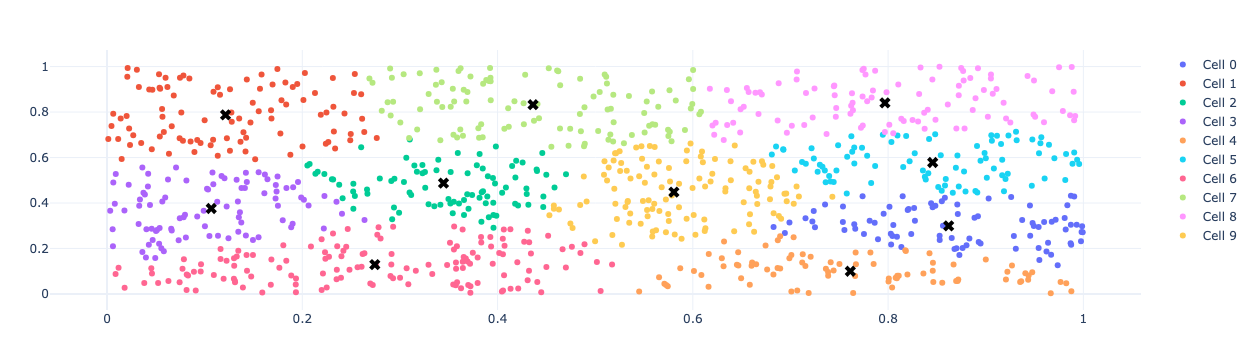

In [551]:
color_map = generate_high_contrast_colors(index2.nlist)
color_array = [color_map[id] for id in cell_ids]

fig_cells = go.Figure()
unique_ids = np.unique(cell_ids)

for uid in unique_ids:
    mask = (cell_ids == uid)

    fig_cells.add_trace(go.Scatter(x=vectors[mask, 0], y=vectors[mask, 1], mode='markers',
                                   marker=dict(size=6), name="Cell {}".format(uid)))

fig_cells.add_trace(go.Scatter(x=centroids[:, 0], y=centroids[:, 1], mode='markers',
                               marker=dict(size=10, symbol='x', color='black'),
                               name="Centroids", showlegend=False))

fig_cells.update_layout(template="plotly_white", margin=dict(t=50, b=50, l=50, r=50))
fig_cells

In [539]:
index2.add(vectors)

In [540]:
%%time 
distances, indices = index2.search(search_vector, k=10)

df_ann = pd.DataFrame({
  "id": indices[0],
  "vector": [vectors[id] for id in indices[0]],
  "distance": distances[0],
})
df_ann

CPU times: user 894 µs, sys: 425 µs, total: 1.32 ms
Wall time: 2.15 ms


,id,vector,distance
0,912,"[0.51214206, 0.49906242]",0.000148
1,645,"[0.4883095, 0.516822]",0.000420
2,934,"[0.5089926, 0.524738]",0.000693
3,448,"[0.5361612, 0.50799084]",0.001371
4,246,"[0.5195626, 0.46237582]",0.001798
5,757,"[0.52554846, 0.54038584]",0.002284
6,804,"[0.5450408, 0.5175769]",0.002338
7,291,"[0.55084914, 0.48862478]",0.002715
8,339,"[0.5322941, 0.5421502]",0.002820
9,540,"[0.513797, 0.5562368]",0.003353


In [541]:
ann_vectors = np.array(df_ann["vector"].tolist())

common_indices = set(df_ann["id"]).intersection(df_flat["id"])
common_vectors = np.array([vectors[id] for id in common_indices])

In [549]:
index2.quantizer.search(search_vector, k=1)

(array([[0.00921615]], dtype=float32), array([[9]]))

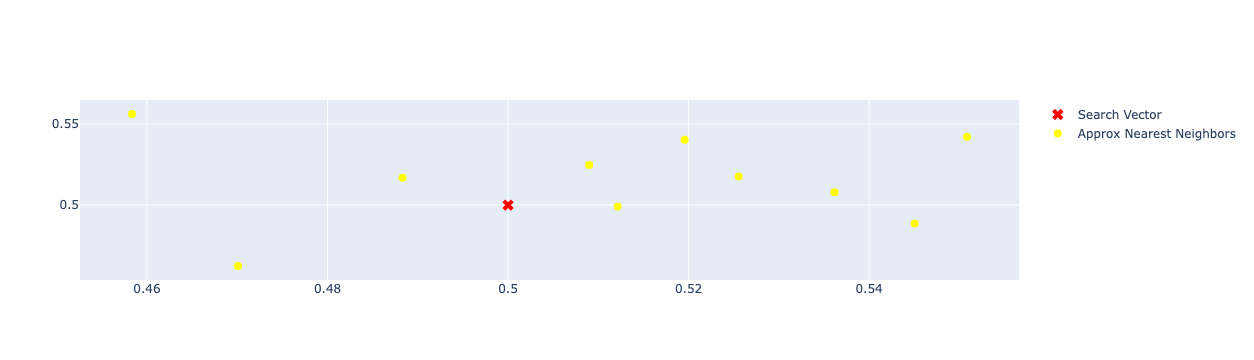

In [548]:
ann_fig = go.Figure()
ann_fig.add_trace(go.Scatter(x=search_vector[:, 0], y=search_vector[:, 1], mode='markers', marker=dict(size=10, color='red', symbol='x'), name="Search Vector"))
ann_fig.add_trace(go.Scatter(x=nn_vectors[:, 0], y=ann_vectors[:, 1], mode='markers', marker=dict(size=8, color='yellow'), name="Approx Nearest Neighbors"))

ann_fig

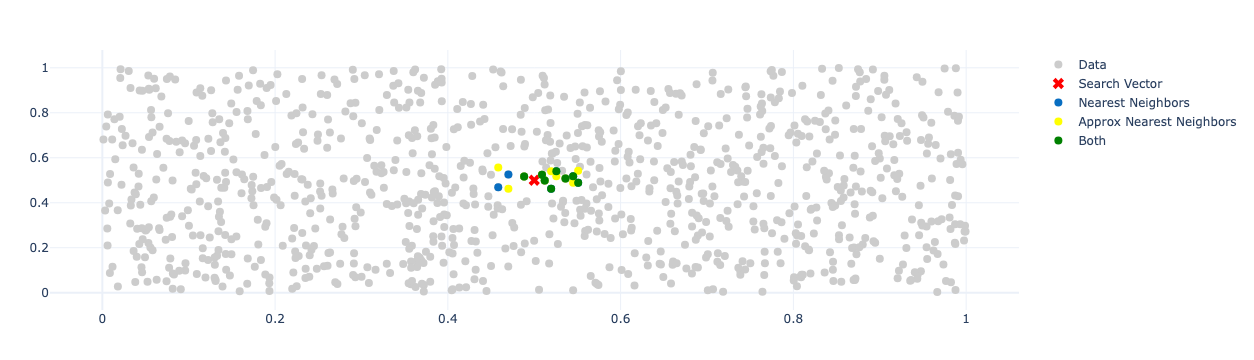

In [547]:
ann_fig = copy.deepcopy(nn_fig)
ann_fig.add_trace(go.Scatter(x=nn_vectors[:, 0], y=ann_vectors[:, 1], mode='markers', marker=dict(size=8, color='yellow'), name="Approx Nearest Neighbors"))

if len(common_vectors) > 0:
  ann_fig.add_trace(go.Scatter(x=common_vectors[:, 0], y=common_vectors[:, 1], mode='markers', marker=dict(size=8, color='green'), name="Both"))

ann_fig

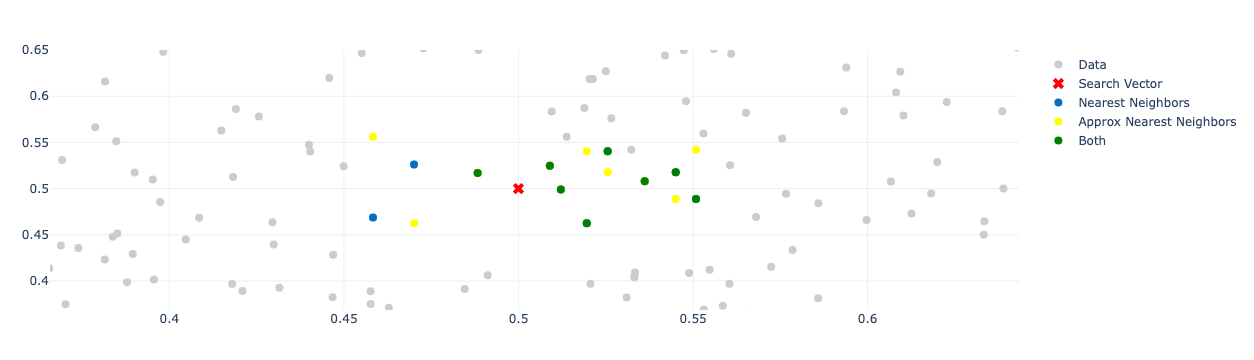

In [543]:
zoom_in(ann_fig, common_vectors, search_vector, nn_vectors, ann_vectors)

In [496]:
%%time 
index2.nprobe = 4
distances, indices = index2.search(search_vector, k=10)

df_ann = pd.DataFrame({
  "id": indices[0],
  "vector": [vectors[id] for id in indices[0]],
  "distance": distances[0],
})
df_ann

CPU times: user 925 µs, sys: 134 µs, total: 1.06 ms
Wall time: 971 µs


,id,vector,distance
0,954,"[0.8393122, 0.6878734]",0.000100
1,239,"[0.7121781, 0.02661314]",0.000111
2,17,"[0.82494956, 0.9050409]",0.000757
3,814,"[0.4617705, 0.2323283]",0.000773
4,765,"[0.9088058, 0.080357194]",0.000774
5,251,"[0.6869354, 0.44143084]",0.001015
6,316,"[0.39643365, 0.60093474]",0.001476
7,818,"[0.67051077, 0.26112416]",0.002163
8,473,"[0.7921833, 0.44813257]",0.002490
9,526,"[0.5306618, 0.6426996]",0.002572


In [34]:
n_bits = 2 * dimensions
lsh = faiss.IndexLSH (dimensions, n_bits)
lsh.train (vectors)
lsh.add (vectors)

In [493]:
%%time
distances, indices = lsh.search (search_vector, k=10)
pd.DataFrame({
  "id": indices[0],
  "vector": [vectors[id] for id in indices[0]],
  "distance": distances[0],
})

NameError: name 'lsh' is not defined